<a href="https://colab.research.google.com/github/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/ayvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico 1 - Análisis y Visualización de Datos

Trabajaremos sobre los datos anonimizados de compras de una plataforma de cursos onlines. Exploraremos las distintas fuentes de datos y haremos un análisis descriptivo y visual de los datos para entender cómo están distribuidas las ventas.

El dataset está constituido por tres bases: clientes, ventas y contactos. Hay diversos análisis que se pueden hacer a partir de las mismas: segmentación de clientes, análisis de texto de las consultas, análisis de series de tiempo de las ventas, etc.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy
import pandas as pd
import seaborn as sns
import requests
from datetime import datetime, timedelta

## Lectura de los datasets

Funcion para leer los datos de Github

In [2]:
def read_from_raw(github_url):
  raw_url = github_url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
  return pd.read_csv(raw_url, encoding = "ISO-8859-1")

Carga del set de datos contactos

In [3]:
df_contacts = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/contacts_anon.csv')
df_contacts[:3]

,id,fecha,nombre,email,genero,asunto,mensaje
0,80242452935422199706,16/03/2024 14:55:28,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,M,Consulta general,. quisiera saber si existe algun simulador del...
1,15409661513166318845,13/03/2024 16:13:09,Apolinar Jimenez Teruel,apolinar.jimenez.teruel6338@gmail.com,M,Consulta general,no puedo ver los videos del curso. necesito ayuda
2,67687345747217393942,12/03/2024 18:47:42,Evangelina Clotilde Requena Sans,evangelina.clotilde.requena.sans5853@gmail.com,F,Consulta general,"hola, me surge una duda de la ley . mujer de a..."


Carga del set de datos customers

In [4]:
df_customers = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/customers_anon.csv')
df_customers[:3]

,id,nombre,email,genero
0,87383708928538182091,Sancho Quesada,sancho.quesada631@gmail.com,M
1,90963905505013869370,Rosario Donoso,rosario.donoso4687@hotmail.com,F
2,36171761627209661626,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,M


Carga del set de datos orders

In [5]:
df_orders = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/orders_anon.csv')
df_orders.head(3)

,número,Fecha,moneda,monto total,cant. de productos,estado del pago,medio de pago,estado de la entrega,forma de entrega,envío: dirección,envío: código postal,producto: código / sku,producto: cantidad,producto: precio,código país,código área,nombre,email,producto,codigo_promocional
0,5285,17/03/2024 03:29:27,ARS,20280.0,1,Pagado,Mercadopago,NaN,NaN,NaN,NaN,NaN,1,20280.0,54.0,NaN,Sancho Quesada,sancho.quesada631@gmail.com,Curso 2,NaN
1,5284,16/03/2024 14:33:27,ARS,20280.0,1,Pagado,Mercadopago,NaN,NaN,NaN,NaN,NaN,1,20280.0,54.0,297.0,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,Curso 2,NaN
2,5283,15/03/2024 19:21:18,ARS,20280.0,1,Pendiente,Mercadopago,NaN,NaN,NaN,NaN,NaN,1,20280.0,54.0,351.0,María Saldaña,maria.saldana6060@gmail.com,Curso 2,NaN


In [6]:
df_orders.tail(3)

,número,Fecha,moneda,monto total,cant. de productos,estado del pago,medio de pago,estado de la entrega,forma de entrega,envío: dirección,envío: código postal,producto: código / sku,producto: cantidad,producto: precio,código país,código área,nombre,email,producto,codigo_promocional
5251,13,05/04/2021 17:55:22,ARS,22.0,1,Pagado,Transferencia bancaria a cuenta virtual (CVU),NaN,NaN,NaN,NaN,NaN,1,22.0,54.0,341.0,Zacarías Tamarit Aroca,zacarias.tamarit.aroca6299@yahoo.com,Curso 11,NaN
5252,12,05/04/2021 16:52:28,ARS,22.0,1,Pagado,Transferencia bancaria a cuenta virtual (CVU),NaN,NaN,NaN,NaN,NaN,1,22.0,54.0,341.0,Marcial Jurado Pino,marcial.jurado.pino8447@hotmail.com,Curso 11,NaN
5253,10,05/04/2021 16:38:09,ARS,78.0,1,Pagado,Mercadopago,NaN,NaN,NaN,NaN,NaN,1,78.0,54.0,341.0,Marcial Jurado Pino,marcial.jurado.pino8447@hotmail.com,Curso 2,NaN


In [7]:
df_orders['codigo_promocional'].unique()

array([nan, 'Promo 1', 'Promo 10', 'Promo 7', 'Promo 9', 'Promo 4',
       'Promo 5', 'Promo 8', 'Promo 2', 'Promo 6', 'Promo 3'],
      dtype=object)

## Analisis de series de tiempo de las ventas

Comenzaremos el analisis determinando si existen valores faltantes en el dataset, primero haremos un análisis de valores nulos. Luego, dependiendo de los resultados, consideraremos las posibles causas y cómo tratar estos valores faltantes.

**1. Verificar los valores faltantes**

In [8]:
missing_values = df_orders.isnull().sum()
missing_values_percentage = (missing_values / len(df_orders)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percentage})
print(missing_data.sort_values(by='Missing Values', ascending=False))


                        Missing Values  Percentage
envío: código postal              5254  100.000000
estado de la entrega              5254  100.000000
producto: código / sku            5254  100.000000
envío: dirección                  5254  100.000000
forma de entrega                  5254  100.000000
codigo_promocional                5122   97.487628
código área                       1320   25.123715
código país                          7    0.133232
medio de pago                        0    0.000000
estado del pago                      0    0.000000
cant. de productos                   0    0.000000
monto total                          0    0.000000
Fecha                                0    0.000000
moneda                               0    0.000000
producto: cantidad                   0    0.000000
producto: precio                     0    0.000000
nombre                               0    0.000000
email                                0    0.000000
producto                       

**2. Posibles causas de valores faltantes:**

* Errores durante la recolección de datos.
* Información no disponible en el momento de la recolección.
* Problemas en la importación de datos.
* Falta de voluntad de los usuarios

**3. Tratamiento de valores faltantes:**

* **Eliminar filas/columnas**: Si hay muchas filas o columnas con valores faltantes, puedes considerar eliminarlas.
* **Imputación**: Se vera en Analisis y curacion de datos

Procederemos a eliminar aquellas columnas que carecen de la mayoria de sus datos

In [9]:
columns_to_drop = ['envío: código postal', 'estado de la entrega', 'producto: código / sku',
                   'envío: dirección', 'forma de entrega']
df_orders = df_orders.drop(columns=columns_to_drop)
print(df_orders.columns)


Index(['número', 'Fecha', 'moneda', 'monto total', 'cant. de productos',
       'estado del pago', 'medio de pago', 'producto: cantidad',
       'producto: precio', 'código país', 'código área', 'nombre', 'email',
       'producto', 'codigo_promocional'],
      dtype='object')


Para nuestro analisis de serie de tiempo consideramos como variables esenciales a la columna **Fecha** y **Monto Total**

Para ello, primero necesitamos asegurarnos de que las fechas y los montos de las ventas están en el formato adecuado.

Por lo tanto vamos a seguir los siguientes pasos:


Para evitar tener que lidiar con el problema de la inflacion Argentina, vamos a exportar un set de datos con el tipo de cambio historico. (Originalmente de la pagina del banco nacion).

In [10]:
exchange_rates_df = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/tipos-de-cambio-historicos.csv')
exchange_rates_df[:3]

,Fecha,USD
0,2021-01-01,84.145
1,2021-01-02,84.145
2,2021-01-03,84.145


Luego de transformar el set en un DataFrame de pandas, hacemos un join con nuestro set de ventas (df_orders) para convertir los montos de todas las ventas a dolares.

In [11]:
df_orders['Fecha'] = pd.to_datetime(df_orders['Fecha'], format='%d/%m/%Y %H:%M:%S').dt.date
exchange_rates_df['Fecha'] = pd.to_datetime(exchange_rates_df['Fecha'], format='%Y-%m-%d').dt.date

df_merged = pd.merge(df_orders, exchange_rates_df, on='Fecha', how='left')

# Calcular los montos en USD
df_merged['monto total USD'] = df_merged['monto total'] / df_merged['USD']
df_merged['monto total USD'] = df_merged['monto total USD'].round(2)

# Mostrar las primeras filas para verificar la nueva columna
print(df_merged[['Fecha', 'monto total', 'USD', 'monto total USD']].head())


        Fecha  monto total     USD  monto total USD
0  2024-03-17      20280.0  850.75            23.84
1  2024-03-16      20280.0  850.75            23.84
2  2024-03-15      20280.0  850.75            23.84
3  2024-03-15      86658.0  850.75           101.86
4  2024-03-15      86658.0  850.75           101.86


**Convertiremos las columnas de fechas al tipo de datos datetime.**

In [12]:
df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'], format='%Y-%m-%d')
df_merged.set_index('Fecha', inplace=True)
df_merged.head(3)

,número,moneda,monto total,cant. de productos,estado del pago,medio de pago,producto: cantidad,producto: precio,código país,código área,nombre,email,producto,codigo_promocional,USD,monto total USD
Fecha,,,,,,,,,,,,,,,,
2024-03-17,5285,ARS,20280.0,1,Pagado,Mercadopago,1,20280.0,54.0,NaN,Sancho Quesada,sancho.quesada631@gmail.com,Curso 2,NaN,850.75,23.84
2024-03-16,5284,ARS,20280.0,1,Pagado,Mercadopago,1,20280.0,54.0,297.0,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,Curso 2,NaN,850.75,23.84
2024-03-15,5283,ARS,20280.0,1,Pendiente,Mercadopago,1,20280.0,54.0,351.0,María Saldaña,maria.saldana6060@gmail.com,Curso 2,NaN,850.75,23.84


**Agregamos columnas para el Año y el Mes**

In [13]:
df_merged['Year'] = df_merged.index.year
df_merged['Month'] = df_merged.index.month
df_merged.sample(5, random_state=0)

,número,moneda,monto total,cant. de productos,estado del pago,medio de pago,producto: cantidad,producto: precio,código país,código área,nombre,email,producto,codigo_promocional,USD,monto total USD,Year,Month
Fecha,,,,,,,,,,,,,,,,,,
2021-04-05,4,ARS,70.0,1,Pagado,Transferencia bancaria a cuenta virtual (CVU),1,70.0,54.0,341.0,Alonso Cortina Martín,alonso.cortina.martin2274@yahoo.com,Curso 2,NaN,92.2367,0.76,2021,4
2023-05-06,4027,ARS,6700.0,1,Pagado,Mercadopago,1,6700.0,54.0,3476.0,Francisca de Garriga,francisca.de.garriga588@gmail.com,Curso 2,NaN,226.1917,29.62,2023,5
2023-01-04,3044,ARS,5800.0,1,Pendiente,Mercadopago,1,5800.0,54.0,341.0,Juanita Crespo-Vives,juanita.crespo.vives1892@yahoo.com,Curso 2,NaN,178.6533,32.47,2023,1
2021-09-10,875,ARS,3500.0,1,Pagado,Mercadopago,1,3500.0,54.0,NaN,Roldán Conrado Bermúdez Bastida,roldan.conrado.bermudez.bastida9914@hotmail.com,Curso 2,NaN,98.0967,35.68,2021,9
2023-03-08,3523,ARS,6700.0,1,Pendiente,Mercadopago,1,6700.0,54.0,NaN,Martirio Salinas Jover,martirio.salinas.jover6811@yahoo.com,Curso 2,NaN,200.0267,33.50,2023,3


**Agrupamos los datos por fecha para obtener las ventas totales por día.**

In [14]:
#sales_time_series = df_merged.groupby(df_merged['Fecha'])['monto total USD'].sum()
sales_time_series = df_merged.groupby(level=0)['monto total USD'].sum()
print(sales_time_series)

Fecha
2021-04-05      8.71
2021-04-14     33.45
2021-04-18    101.85
2021-04-19     67.80
2021-04-20     67.76
               ...  
2024-03-13    161.35
2024-03-14    299.24
2024-03-15    329.42
2024-03-16     23.84
2024-03-17     23.84
Name: monto total USD, Length: 973, dtype: float64


**Visualizar la serie de tiempo de las ventas.**

A simple vista el grafico de ventas totales por dia no muestra una regularidad evidente,

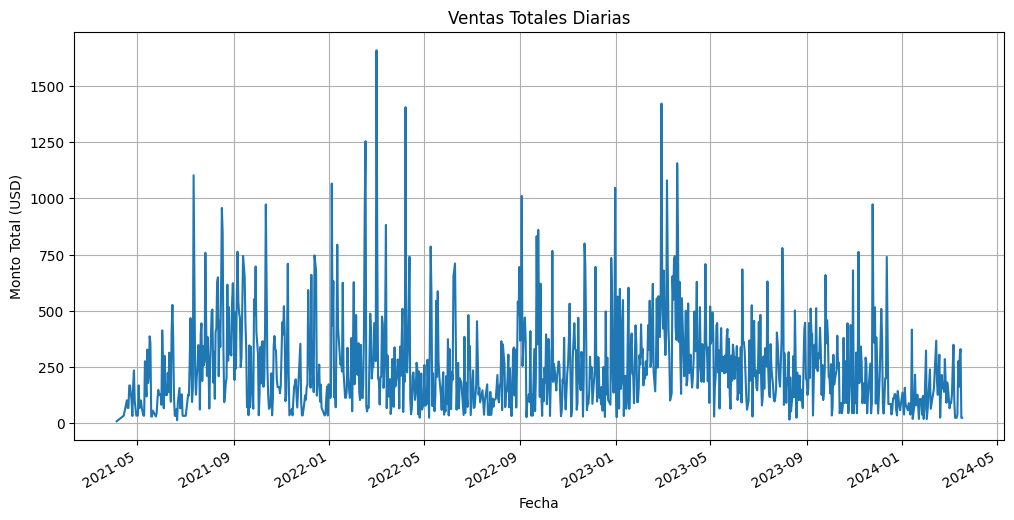

In [15]:
plt.figure(figsize=(12, 6))
sales_time_series.plot()
plt.title('Ventas Totales Diarias')
plt.xlabel('Fecha')
plt.ylabel('Monto Total (USD)')
plt.grid(True)
plt.show()

En este caso probamos el analisis agrupando las ventas totales por mes en toda la serie de tiempo, pero en principio no emerge ninguna regularidad evidente a simple vista.



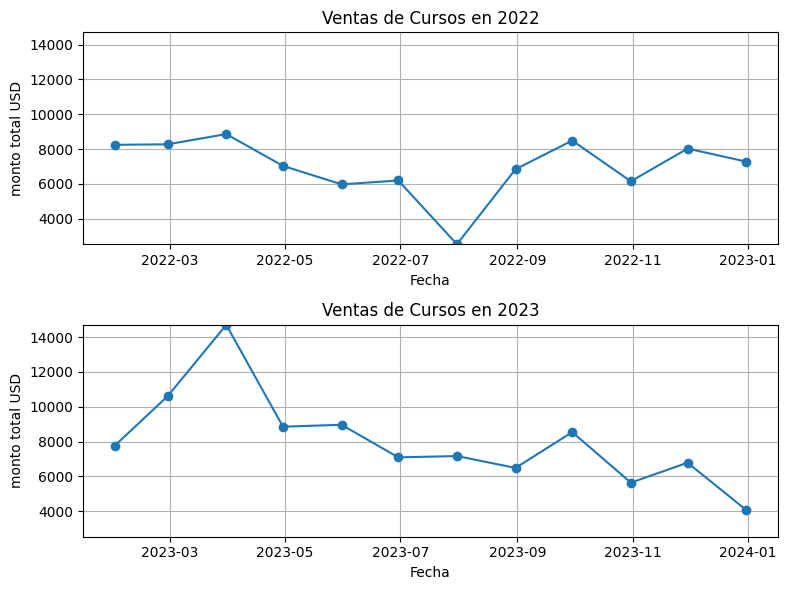

In [24]:
# Filtrar los datos por año
df_2022 = df_merged.loc['2022', 'monto total USD'].resample('M').sum()
df_2023 = df_merged.loc['2023', 'monto total USD'].resample('M').sum()

# Crear los subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Graficar datos de 2022
axes[0].plot(df_2022, marker='o', linestyle='-')
axes[0].set_title('Ventas de Cursos en 2022')

# Graficar datos de 2023
axes[1].plot(df_2023, marker='o', linestyle='-')
axes[1].set_title('Ventas de Cursos en 2023')

# Encontrar los límites del eje y que abarcan ambos plots
min_y = min(df_2022.min(), df_2023.min())
max_y = max(df_2022.max(), df_2023.max())

# Etiquetas y formato
for ax in axes:
    ax.set_xlabel('Fecha')
    ax.set_ylabel('monto total USD')
    ax.grid(True)

    # Establecer los mismos límites del eje y en ambos subplots
    ax.set_ylim(min_y, max_y)

plt.tight_layout()
plt.show()

En el proximo analisis agrupamos todas las ventas acumuladas por semana en todo el año 2022. En este caso lo que se ve con bastante claridad es como se dan con mucha frecuencia los picos de venta los comienzos de cada mes.

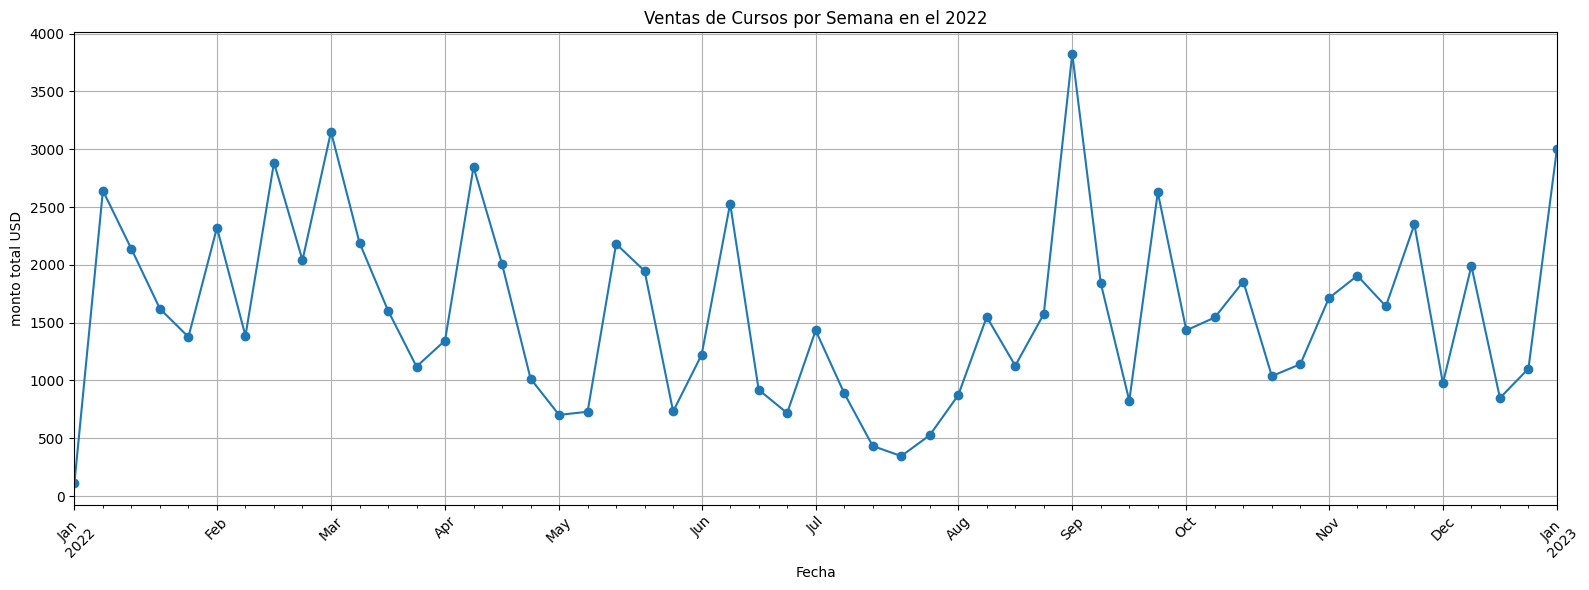

In [17]:
#ventas_semanales = df_merged['monto total USD'].resample('W').sum().reset_index()
ventas_semanales = df_merged.loc['2022', 'monto total USD'].resample('W').sum()

# Crear el gráfico de líneas
plt.figure(figsize=(16, 6))
ax = ventas_semanales.plot(marker='o', linestyle='-')

plt.title('Ventas de Cursos por Semana en el 2022')
plt.xlabel('Fecha')
plt.ylabel('monto total USD')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La siguiente es una observacion sobre las ventas acumuladas por dia en los primeros 6 meses del año 2023. Del grafico parece emerger una regularidad de picos de ventas los primeros dias de cada semana y por el otro lado caidas recurentes los fines de semana.

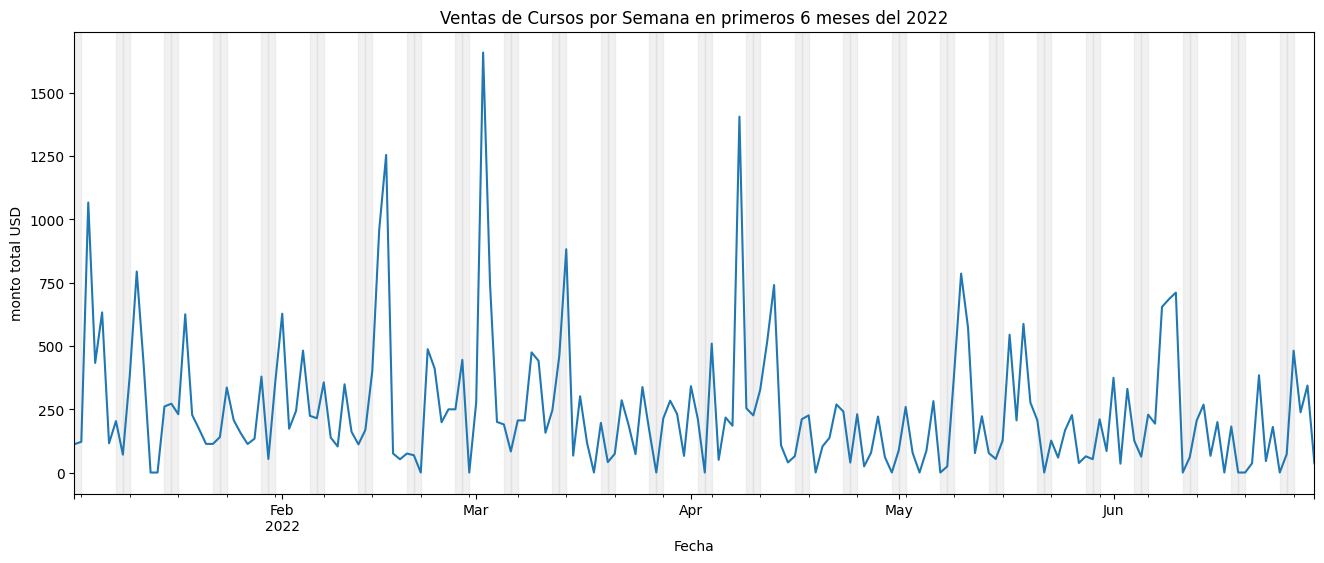

In [18]:
df_merged = df_merged.sort_index()
ventas_diarias = df_merged.loc['2022-01':'2022-06', 'monto total USD'].resample('D').sum()

plt.figure(figsize=(16, 6))
plt.title('Ventas de Cursos por Semana en primeros 6 meses del 2022')
ax = ventas_diarias.plot(linestyle='-')
ax.set_ylabel('monto total USD')

# Marcar los fines de semana
weekends = ventas_diarias.index[ventas_diarias.index.weekday >= 5]  # Filtrar los días sábado (5) y domingo (6)
for weekend in weekends:
    plt.axvspan(weekend, weekend + pd.Timedelta(days=1), color='lightgrey', alpha=0.3)

Ahora vamos a intentar buscar esta misma regularidad extendiendo el alcance del analisis a los años 2021, 2022, 2023.

En los tres graficos aqui abajo, se puede ver emerger el mismo patron en cada unos de los años.

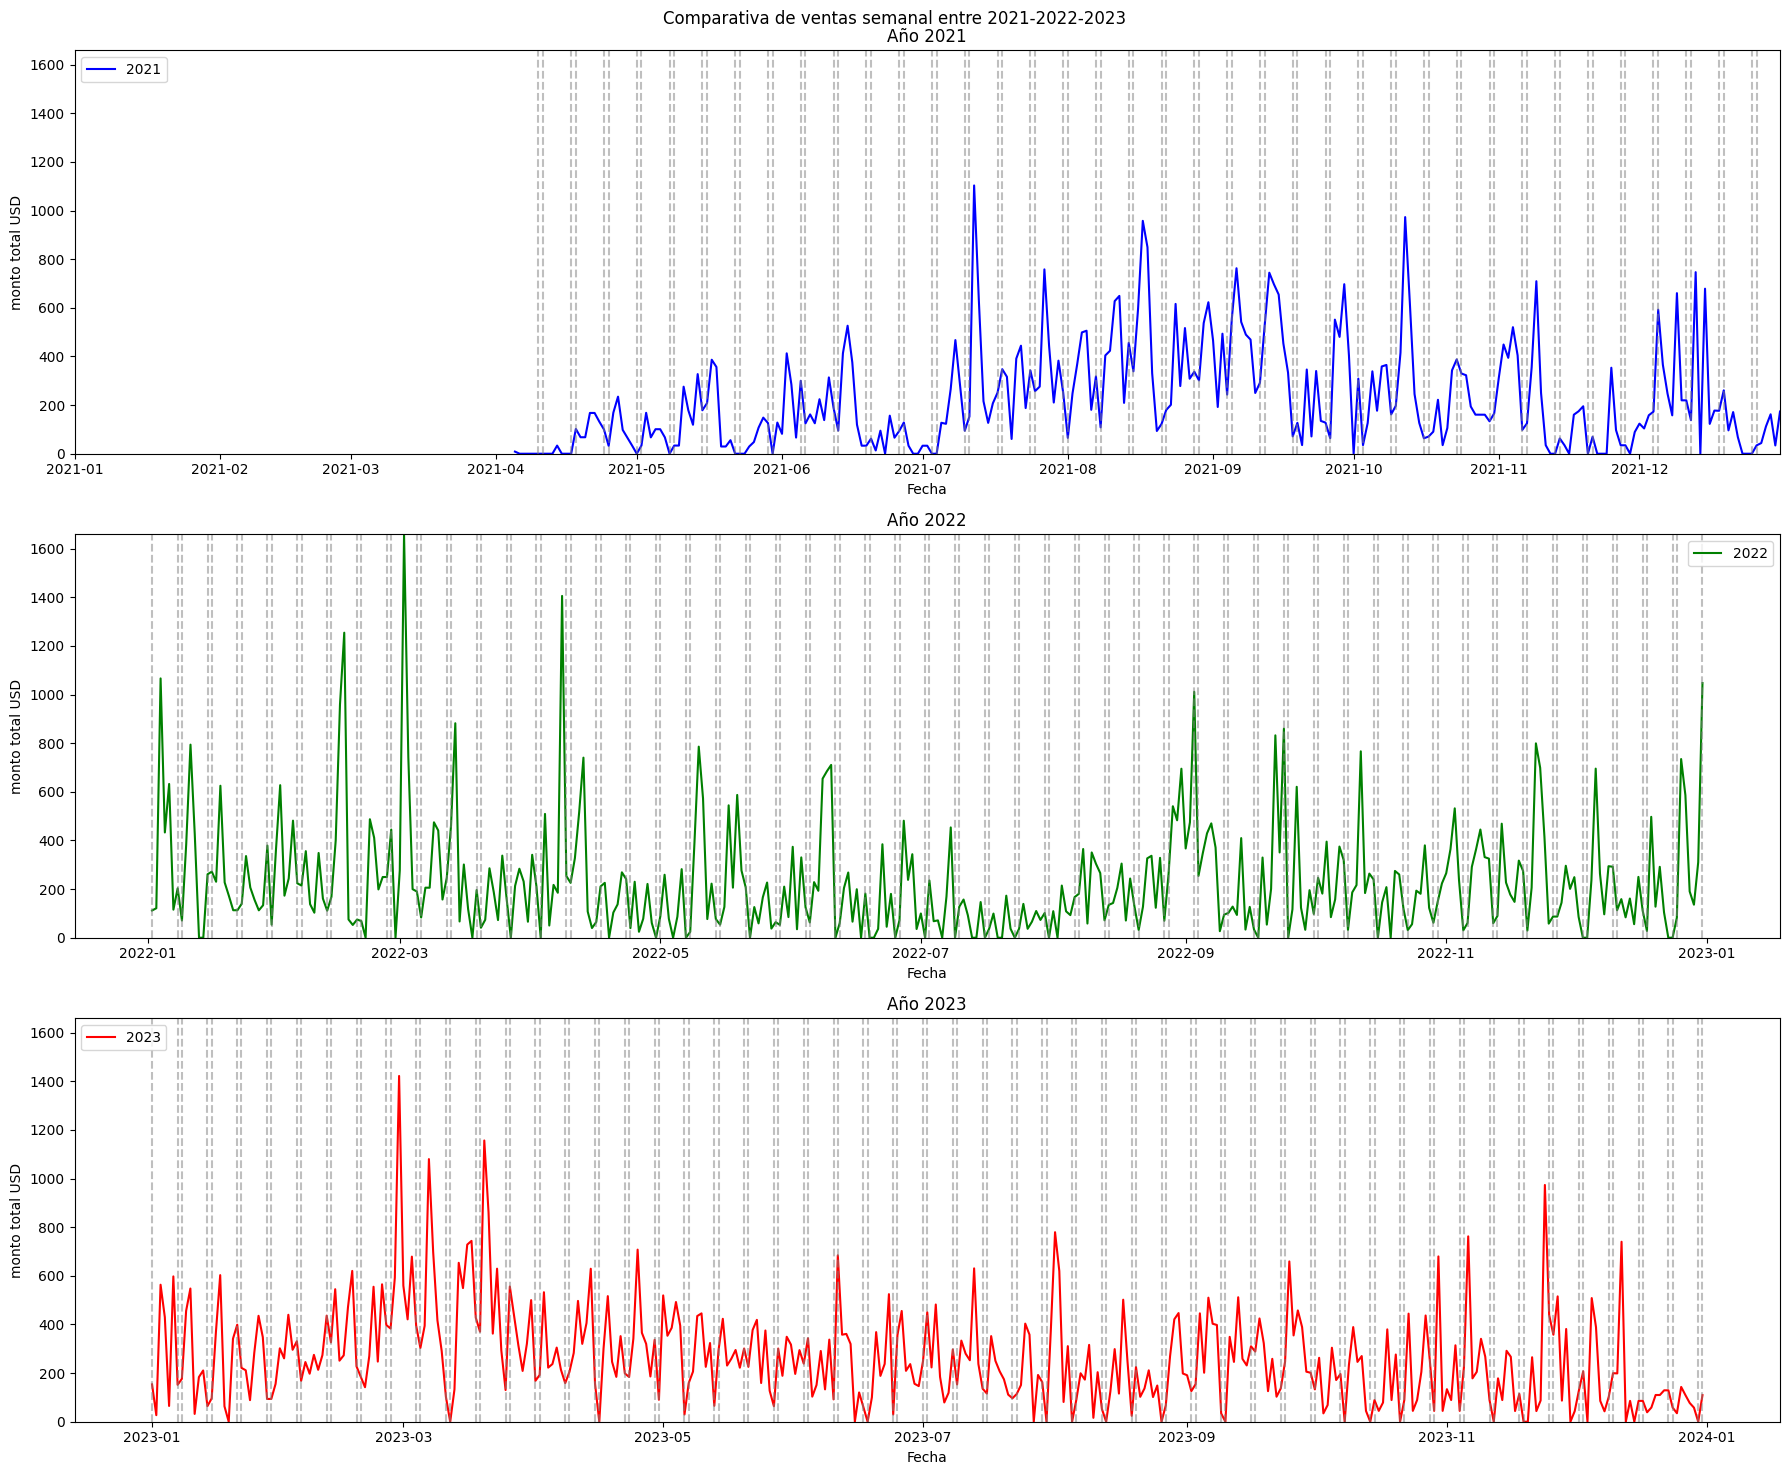

In [32]:
df_2021 = df_merged.loc['2021', 'monto total USD'].resample('D').sum()
df_2022 = df_merged.loc['2022', 'monto total USD'].resample('D').sum()
df_2023 = df_merged.loc['2023', 'monto total USD'].resample('D').sum()

# Función para añadir líneas de fines de semana
def marcar_fines_de_semana(ax, fechas):
    for fecha in fechas:
        if fecha.weekday() >= 5:  # Sábado y domingo
            ax.axvline(x=fecha, color='gray', linestyle='--', alpha=0.5)

# Crear subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 15))
fig.suptitle('Comparativa de ventas semanal entre 2021-2022-2023')

# Datos del año 2021
axs[0].plot(df_2021, label='2021', color='blue')
marcar_fines_de_semana(axs[0], df_2021.index)
axs[0].set_title('Año 2021')
axs[0].set_xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2021-12-31'))

# Datos del año 2022
axs[1].plot(df_2022, label='2022', color='green')
marcar_fines_de_semana(axs[1], df_2022.index)
axs[1].set_title('Año 2022')
#axs[1].set_xlim('2022-01', '2022-12')

# Datos del año 2023
axs[2].plot(df_2023, label='2023', color='red')
marcar_fines_de_semana(axs[2], df_2023.index)
axs[2].set_title('Año 2023')
#axs[2].set_xlim('2023-01', '2023-12')

# Encontrar los límites del eje y que abarcan ambos plots
min_y = min(df_2021.min(), df_2022.min(), df_2023.min())
max_y = max(df_2021.max(), df_2022.max(), df_2023.max())

# Etiquetas y formato
for ax in axs:
    ax.set_xlabel('Fecha')
    ax.set_ylabel('monto total USD')
    ax.legend()

    # Establecer los mismos límites del eje y en ambos subplots
    ax.set_ylim(min_y, max_y)

# Ajustar el layout
plt.tight_layout()
plt.show()

Del analisis del caso anterior surge la siguiente pregunta: Cual es el dia de la semana que en promedio produce el mayor numero de ventas? Si los datos son consistentes con el analisis anterior, este dia deberia estar entre el Lunes y el Miercoles.

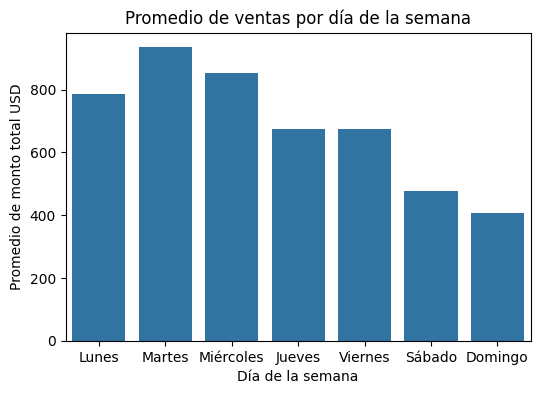

Promedio de ventas por día de la semana:
  dia_semana       sum        mean
0      Lunes  40885.50  786.259615
1     Martes  48614.10  934.886538
2  Miércoles  44297.82  851.881154
3     Jueves  35107.26  675.139615
4    Viernes  35119.89  675.382500
5     Sábado  24799.82  476.919615
6    Domingo  21161.77  406.957115


In [20]:
# Extraer el día de la semana (lunes=0, domingo=6)
df_merged['dia_semana'] = df_merged.index.dayofweek

# Agrupar por día de la semana y sumar las ventas
ventas_por_dia = df_merged.groupby('dia_semana')['monto total USD'].agg(['sum']).reset_index()

# Crear un mapa de nombres de los días de la semana
dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
ventas_por_dia['dia_semana'] = ventas_por_dia['dia_semana'].map(dias_semana)

# Calcular el número de semanas o días en tu serie de tiempo
num_semanas = len(df_merged.index.isocalendar().week.unique())  # Número de semanas únicas en tus datos

# Calcular el promedio de ventas por día de la semana
ventas_por_dia['mean'] = ventas_por_dia['sum'] / num_semanas

# Graficar los resultados
plt.figure(figsize=(6, 4))
sns.barplot(x='dia_semana', y='mean', data=ventas_por_dia)

plt.title('Promedio de ventas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Promedio de monto total USD')
plt.show()

# Imprimir el promedio de ventas por día de la semana
print("Promedio de ventas por día de la semana:")
print(ventas_por_dia)

Como lo muestra muy claramente el grafico anterior, los Martes son el dia que historicamente producen el mayor numero de ventas, mientras que los
Domingos la menor cantidad.

**Visualizar los componentes de tendencia y estacionalidad:**

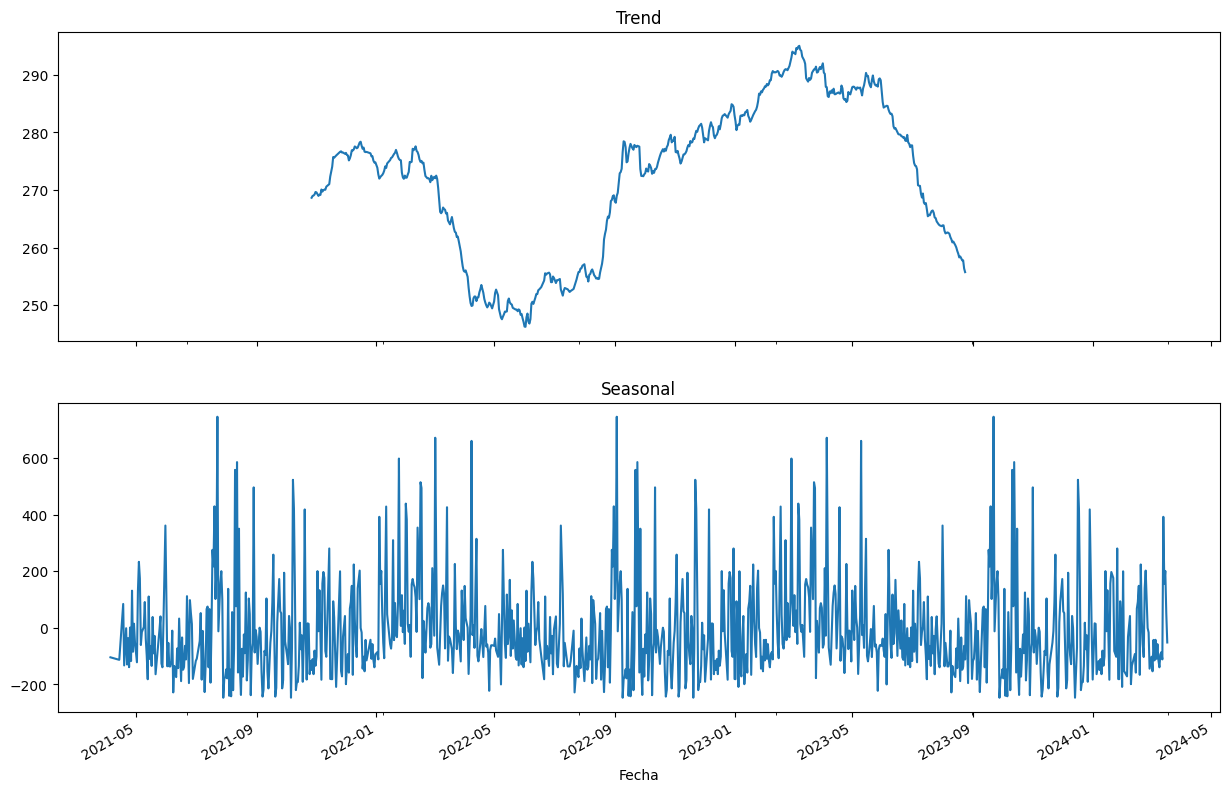

In [21]:
# Descomposición de la serie de tiempo
decomposition = seasonal_decompose(sales_time_series, model='additive', period=365)

# Plot the decomposition
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
decomposition.trend.plot(ax=ax1, title='Trend')
decomposition.seasonal.plot(ax=ax2, title='Seasonal')
plt.show()